# 00b - Extract ISIMIP3a glacier climate change informations:
- creates glacier area-weighted temperature or precipitation averages or changes (globally or per RGI region) : `../0_pre_post_processing/_intermediate_data/climate_input_data/temp_prcp_past_gswp3-w5e5_glacier_regionally.csv`


- there are some plots showing temperature changes of the different glacier regions for different gcms and scenarios. This will be helpful for the interpretation of the glacier projections later on. Some plots use another definition of "temperature change" and can be updated, if they are interesting, to the IPCC definition 

---

In [3]:
# path to isimip3b files that are available under https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/:
# this needs to be changed if not run used on the OGGM cluster
path = '/home/www/oggm/climate/gswp3-w5e5/'

In [1]:
import xarray as xr
import numpy as np
from oggm import utils
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import progressbar
from scipy import stats
import seaborn as sns

# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## some preprocessing to get the glacier gridpoints and their area
- we take the lon/lat gridpoints nearest to the glaciers and create a mask to get later the climate just for those glacier gridpoints. This mask can either be applied to get a global climate change over glacier estimate or a regional estimate 

In [3]:
path_orog = '/home/www/lschuster/isimip3b/'

In [4]:
# updated to new version 2023.2
ds_inv = xr.open_dataset(path_orog+'orog_W5E5v2.0.nc')
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

# get the dataset where coordinates of glaciers are stored
frgi = path_orog + 'rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
# remove those glaciers with connectivity level not at 0 or 1 in RGI region 05:
# check if all glaciers with connectivity level not in 0 or 1 are in RGI region 05 
assert np.all(odf.loc[(odf.Connect != 0) & (odf.Connect != 1)].O1Region == '05')
# ok then just select those glaciers with the right connectivity level ...
odf = odf.loc[(odf.Connect == 0) | (odf.Connect == 1)]


nx, ny = ds_inv.dims['lon'], ds_inv.dims['lat']
# just make them into 0-> 360 scheme
cenlon_for_bins = np.where(odf['CenLon'] < 0,
                           odf['CenLon']+360, odf['CenLon'])
# Nearest neighbor lookup
lon_bins = np.linspace(ds_inv.lon.data[0] - 0.25, ds_inv.lon.data[-1] + 0.25, nx+1)
# !!! attention W5E5 sorted from 90 to -90 !!!!
lat_bins = np.linspace(ds_inv.lat.data[0] + 0.25, ds_inv.lat.data[-1] - 0.25, ny+1)
# before it was wrongly 
# lon_bins = np.linspace(0, 360, nx), lat_bins = np.linspace(90, -90, ny)
# which created a non-aligned bins, in addition there was one bin missing, creating a slightly 
# larger resolution which after adding up a lot got problematic... 
# at the end it resulted in some glaciers where the nearest grid point was not found

odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1

# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of W5E5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

# this is the mask that we need to remove all non-glacierized gridpoints
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area'] # 1
ds_inv['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))

ds_inv['glacier_area'] = (('lat', 'lon'), mask)
ds_inv['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
ds_inv['rgi_region'] = (('lat', 'lon'), reg)


# check the distance to the gridpoints-> it should never be larger than 
diff_lon = ds_inv.lon.data[odf.lon_id] - odf.CenLon
# if the distance is 360 -> it is the same as 0,
diff_lon = np.where(np.abs(diff_lon - 360) < 170, diff_lon-360, diff_lon)
odf['ll_dist_to_point'] = ((diff_lon)**2 + (ds_inv.lat.data[odf.lat_id] - odf.CenLat)**2)**0.5
assert odf['ll_dist_to_point'].max() < (0.25**2 + 0.25**2)**0.5

# Normal Weight
weight = np.cos(np.deg2rad(ds_inv.lat.astype(np.float64))).clip(0)
weight =  ds_inv.orog * 0. + weight
ds_inv['weight'] = (('lat', 'lon'), weight.values / weight.sum().values)

Total number of glaciers: 215547 and number of W5E5 gridpoints with glaciers in them: 4695


In [5]:
print('total glacier area: {} km2'.format(np.nansum(mask)) )

total glacier area: 705738.792 km2


In [6]:
# this should be one
print(ds_inv['weight_glacier'].sum())

<xarray.DataArray 'weight_glacier' ()>
array(1.)


**Some analysis of special characteristics in RGI04**

In [7]:
odf.loc[['RGI60-04.06187','RGI60-04.06188']]['Area'].sum()/odf.loc[odf.O1Region == '04'].Area.sum()

0.0934928018890914

In [8]:
rgis_ice_cap_04 = odf.loc[odf.O1Region == '04'][odf.loc[odf.O1Region == '04'].GlacierType == 'Ice cap'].index

In [9]:
import oggm
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))

vol_ratio_icecap_04 = df_itmix.loc[rgis_ice_cap_04]['vol_itmix_m3'].sum()/df_itmix.loc[odf.loc[odf.O1Region == '04'].index]['vol_itmix_m3'].sum()
vol_ratio_icecap_04

0.5312750779229376

In [10]:
vol_ratio_barnes_icecap = df_itmix.loc[['RGI60-04.06187','RGI60-04.06188']]['vol_itmix_m3'].sum()/df_itmix.loc[odf.loc[odf.O1Region == '04'].index]['vol_itmix_m3'].sum()

## ISIMIP3a average Temperature change at glacier locations for each region separately

In [11]:
exp_times = [1981, 1995, 2000]

# get the right format for the longitudes
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

# weighted average over latitudes
weight_regions = {}
weight_regions['global'] = ds_inv.weight #.sum(dim='lon')

# this is glacier area weighted
weight_regions['global_glacier']  = ds_inv.weight_glacier
# the glacier regional weight files need to be longitude dependent!!!
for rgi_reg in range(1, 20):
    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
    weight_reg = weight_reg / weight_reg.sum()
    weight_regions[f'RGI{rgi_reg:02g}_glacier'] = weight_reg
regions = weight_regions.keys()

In [4]:
path_output_f_pr = path + 'unflattened/monthly/gswp3-w5e5_obsclim_pr_global_monthly_1901_2019.nc'
ds_obs_pr = xr.open_dataset(path_output_f_pr)
ds_pr_yearly = ds_obs_pr.groupby('time.year').mean()
ds_pr_yearly.coords['lon'] = np.where(ds_pr_yearly.lon.values < 0, ds_pr_yearly.lon.values + 360,
                                  ds_pr_yearly.lon.values)
ds_pr_yearly = ds_pr_yearly.sortby(ds_pr_yearly.lon)

In [9]:
ds_pr_yearly.pr.units

'kg m-2 s-1'

In [13]:
path_output_f = path + 'unflattened/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019.nc'
ds_obs = xr.open_dataset(path_output_f)

ds_obs.coords['lon'] = np.where(ds_obs.lon.values < 0, ds_obs.lon.values + 360,
                                  ds_obs.lon.values)
ds_obs = ds_obs.sortby(ds_obs.lon)
ds_tas_yearly = ds_obs.groupby('time.year').mean()

ds_tas_yearly_min = ds_obs.groupby('time.year').min()
ds_tas_yearly_max = ds_obs.groupby('time.year').max()
# continentality index.... defined as the temperature difference between the 
# coldest and warmest month of the same year averaged over some past period (e.g. Woul, 2005; Hock 2009; Holmlund and Schneider, 1997)
ds_tas_yearly_diff = (ds_tas_yearly_max-ds_tas_yearly_min)

In [14]:
pd_global_temp_exp = pd.DataFrame(columns=['observational_dataset','period', 'average_change', 'average', 'variable','region'])

temp_ch_avg_l = []
period_l =[]
region_l = []
rgi_reg_l = []
temp_avg_l = []
typ = 'tas'
for region in regions:
    if region == 'global':
        _rgi_reg = 'global'
    elif region == 'global_glacier':
        _rgi_reg = 'All'
    else:
        _rgi_reg = region[3:5]

    
    weight_sel = weight_regions[region]
    np.testing.assert_allclose(weight_sel.lon.values, ds_tas_yearly.lon.values)
    np.testing.assert_allclose(weight_sel.sum(),1)
    
    global_tas_mean = (ds_tas_yearly.tas * weight_sel).sum(dim='lon').sum(dim='lat') - 273.15  # from K to °C
    
    if region == 'global':
        global_tas_mean_test = (ds_tas_yearly.tas.mean(dim='lon') * weight_sel.sum(dim='lon')).sum(dim='lat') - 273.15  # from K to °C
        np.testing.assert_allclose(global_tas_mean, global_tas_mean_test, rtol=1e-3)
    
    exp_period_avg_1901 = global_tas_mean.sel(year=slice(str(1901), str(1920+19))).mean(dim='year')

    for exp_time in exp_times:
        exp_period_avg = global_tas_mean.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
        
        # temp. change 
        period_l.append(f'{str(exp_time)}-{str(exp_time+19)}_vs_1901-1920')
        temp_ch_avg_l.append((exp_period_avg-exp_period_avg_1901).values)
        region_l.append(region)
        rgi_reg_l.append(_rgi_reg)
        temp_avg_l.append(np.NaN)
        
        # now the absolute values
        period_l.append(f'{str(exp_time)}-{str(exp_time+19)}')
        temp_ch_avg_l.append(np.NaN)
        temp_avg_l.append(exp_period_avg)
        region_l.append(region)
        rgi_reg_l.append(_rgi_reg)

        
    # temp. change ... 
    ref_period_avg = global_tas_mean.sel(year = slice(str(1986),str(2005))).mean()
    period_l.append(f'{str(1986)}-{str(2005)}_vs_1901-1920')
    temp_ch_avg_l.append((ref_period_avg-exp_period_avg_1901).values)
    region_l.append(region)
    rgi_reg_l.append(_rgi_reg)
    temp_avg_l.append(np.NaN)

pd_global_temp_exp['period'] = period_l
pd_global_temp_exp['rgi_reg'] = rgi_reg_l
pd_global_temp_exp[f'average_change'] = np.array(temp_ch_avg_l)
pd_global_temp_exp[f'average'] = np.array(temp_avg_l)
pd_global_temp_exp['region'] = region_l
pd_global_temp_exp['observational_dataset'] = 'gswp3-w5e5'
pd_global_temp_exp['variable'] = 'temperature'


pd_global_prcp_exp = pd.DataFrame(columns=['observational_dataset','period','region'])

typ = 'pr'
period_l = []
prcp_avg_l = []
prcp_ch_avg_l = []
region_l  = []
rgi_reg_l = []
for region in regions:
    if region == 'global':
        _rgi_reg = 'global'
    elif region == 'global_glacier':
        _rgi_reg = 'All'
    else:
        _rgi_reg = region[3:5]
        
    weight_sel = weight_regions[region]
    np.testing.assert_allclose(weight_sel.lon.values, ds_tas_yearly.lon.values)
    np.testing.assert_allclose(weight_sel.sum(),1)
    
    reg_pr_mean = (ds_pr_yearly.pr* weight_sel).sum(dim='lon').sum(dim='lat')# 

    for exp_time in exp_times:
        # absolut pr values
        exp_period_avg = reg_pr_mean.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
        period_l.append(f'{str(exp_time)}-{str(exp_time+19)}')
        prcp_ch_avg_l.append(np.NaN)
        prcp_avg_l.append(exp_period_avg)
        region_l.append(region)
        rgi_reg_l.append(_rgi_reg)
pd_global_prcp_exp['period'] = period_l
pd_global_prcp_exp['rgi_reg'] = rgi_reg_l
pd_global_prcp_exp[f'average_change'] = np.array(prcp_ch_avg_l)
pd_global_prcp_exp[f'average'] = np.array(prcp_avg_l)
pd_global_prcp_exp['region'] = region_l
pd_global_prcp_exp['observational_dataset'] = 'gswp3-w5e5'
pd_global_prcp_exp['variable'] = 'precipitation'   



pd_global_temp_diff_exp = pd.DataFrame(columns=['observational_dataset','period', 'region'])
typ = 'pr'
period_l = []
temp_diff_avg_l = []
temp_diff_ch_avg_l = []
region_l  = []
rgi_reg_l = []
for region in regions:
    if region == 'global':
        _rgi_reg = 'global'
    elif region == 'global_glacier':
        _rgi_reg = 'All'
    else:
        _rgi_reg = region[3:5]
    
    weight_sel = weight_regions[region]
    np.testing.assert_allclose(weight_sel.lon.values, ds_tas_yearly.lon.values)
    np.testing.assert_allclose(weight_sel.sum(),1)
    
    reg_tas_diff_mean = (ds_tas_yearly_diff.tas* weight_sel).sum(dim='lon').sum(dim='lat')# 
    for exp_time in exp_times:
        # absolut pr values
        exp_period_avg = reg_tas_diff_mean.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
        period_l.append(f'{str(exp_time)}-{str(exp_time+19)}')
        temp_diff_ch_avg_l.append(np.NaN)
        temp_diff_avg_l.append(exp_period_avg)
        region_l.append(region)
        rgi_reg_l.append(_rgi_reg)
pd_global_temp_diff_exp['period'] = period_l
pd_global_temp_diff_exp['rgi_reg'] = rgi_reg_l
pd_global_temp_diff_exp[f'average_change'] = np.array(temp_diff_ch_avg_l)
pd_global_temp_diff_exp[f'average'] = np.array(temp_diff_avg_l)
pd_global_temp_diff_exp['region'] = region_l
pd_global_temp_diff_exp['observational_dataset'] = 'gswp3-w5e5'
pd_global_temp_diff_exp['variable'] = 'temperature_continentality_index'    
    
    
pd_global_clim_exp = pd.concat([pd_global_temp_exp,pd_global_prcp_exp, pd_global_temp_diff_exp])
pd_global_clim_exp.to_csv('../0_pre_post_processing/_intermediate_data/climate_input_data/temp_prcp_past_gswp3-w5e5_glacier_regionally.csv')

In [33]:
pd_global_temp_exp.loc[pd_global_temp_exp.period == '2000-2019']

,observational_dataset,period,avg_change,avg,var,region,rgi_reg
5,gswp3-w5e5,2000-2019,NaN,14.470184,temperature,global,global
12,gswp3-w5e5,2000-2019,NaN,-8.904141,temperature,global_glacier,All
19,gswp3-w5e5,2000-2019,NaN,-2.680121,temperature,RGI01_glacier,01
26,gswp3-w5e5,2000-2019,NaN,1.370370,temperature,RGI02_glacier,02
33,gswp3-w5e5,2000-2019,NaN,-20.251422,temperature,RGI03_glacier,03
40,gswp3-w5e5,2000-2019,NaN,-14.432082,temperature,RGI04_glacier,04
47,gswp3-w5e5,2000-2019,NaN,-11.933206,temperature,RGI05_glacier,05
54,gswp3-w5e5,2000-2019,NaN,1.129139,temperature,RGI06_glacier,06
61,gswp3-w5e5,2000-2019,NaN,-6.555115,temperature,RGI07_glacier,07
68,gswp3-w5e5,2000-2019,NaN,1.092181,temperature,RGI08_glacier,08


In [13]:
pd_global_temp_exp.loc[pd_global_temp_exp.period == '1981-2000_vs_1901-1920']

,observational_dataset,period,temp_ch_avg,region,rgi_reg,avg_change,avg,var
0,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,global,global,0.564876,NaN,temperature
5,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,global_glacier,All,0.604836,NaN,temperature
10,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,RGI01_glacier,01,0.811467,NaN,temperature
15,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,RGI02_glacier,02,0.791786,NaN,temperature
20,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,RGI03_glacier,03,0.538871,NaN,temperature
25,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,RGI04_glacier,04,0.007182,NaN,temperature
30,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,RGI05_glacier,05,0.105877,NaN,temperature
35,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,RGI06_glacier,06,0.114414,NaN,temperature
40,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,RGI07_glacier,07,0.696441,NaN,temperature
45,gswp3-w5e5,1981-2000_vs_1901-1920,NaN,RGI08_glacier,08,0.304640,NaN,temperature


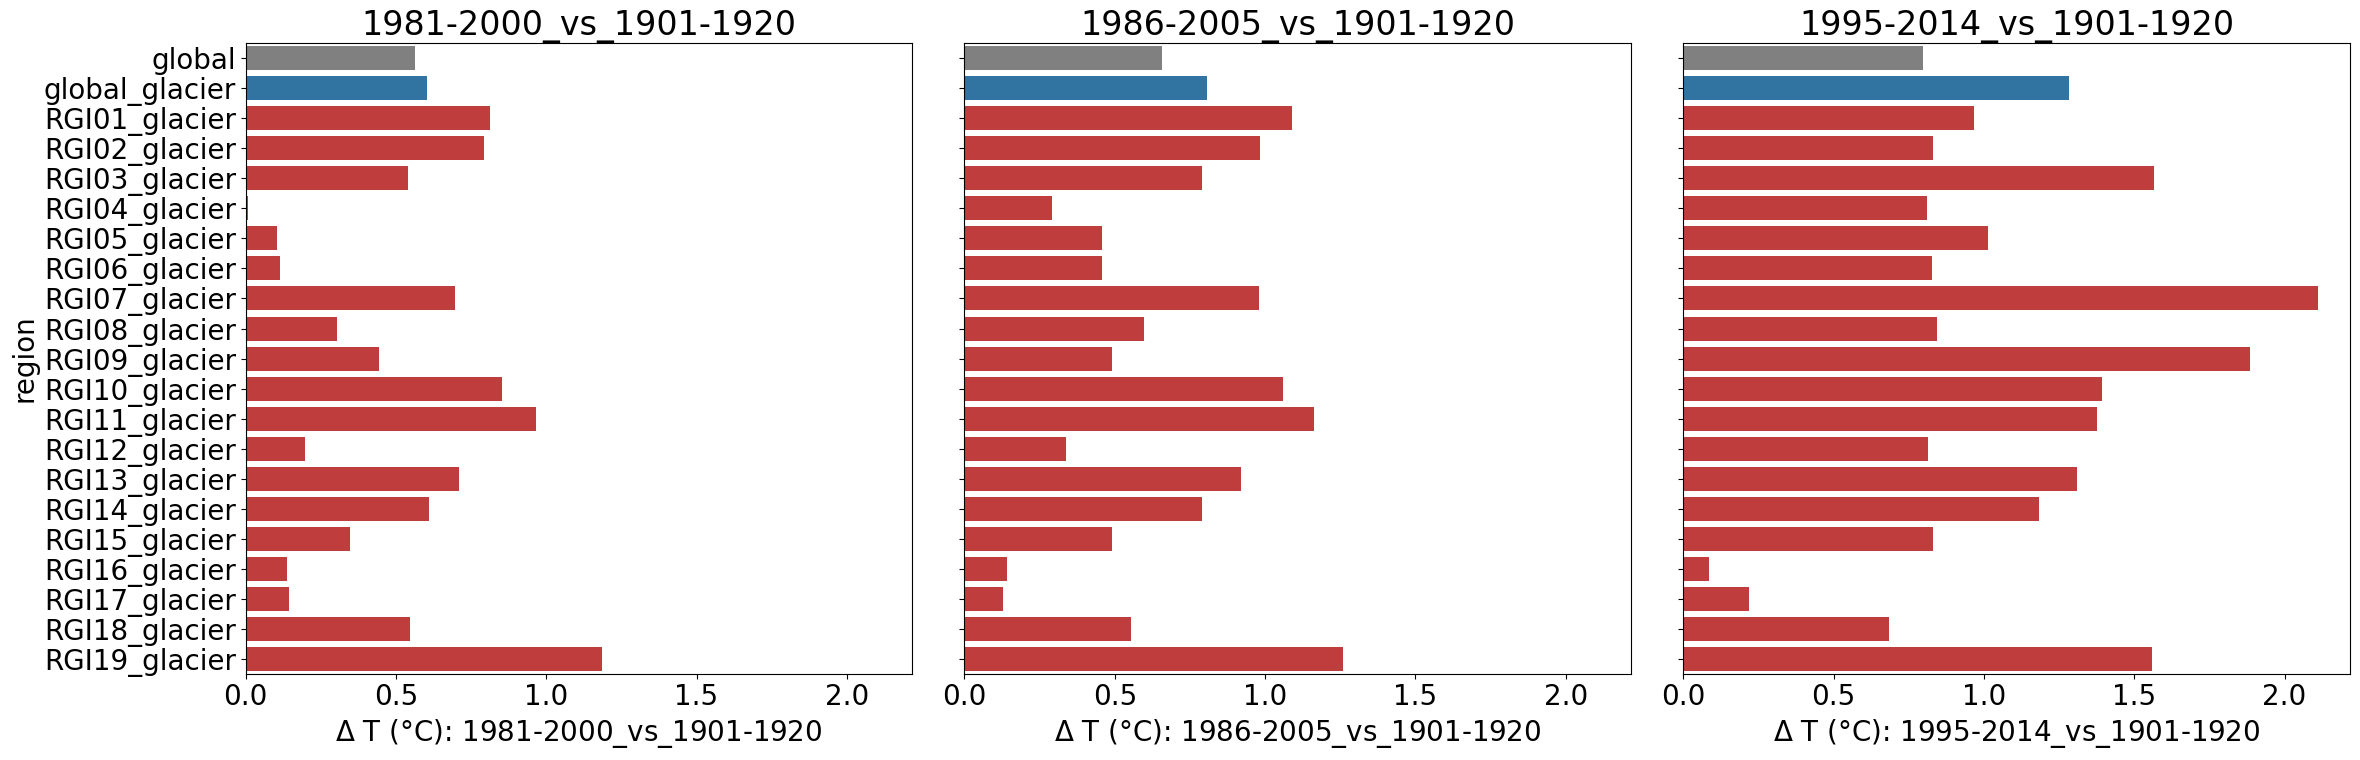

In [88]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1,3,figsize=(24,8), sharey=True, sharex=True)

for ax,period in zip(axs,['1981-2000_vs_1901-1920',f'{str(1986)}-{str(2005)}_vs_1901-1920', '1995-2014_vs_1901-1920']):

    pd_sel = pd_global_temp_exp.loc[pd_global_temp_exp.period == period]
    pd_sel.index = pd_sel.region

    sns.barplot(pd_sel, y='region', x='temp_ch_avg',
                palette=['grey', 'C0']+['C3'] * 19, ax=ax)
    ax.set_xlabel('$\Delta$ T (°C):'+ f' {period}', fontsize=20)
    if '1981' in period:
        ax.set_ylabel('region')
    else:
        ax.set_ylabel('')
    #ax.set_xticks(np.arange(-14,22,2))
    #maxi = pd_sel['temp_ch_avg'].max() +0.5
    #mini = pd_sel['temp_ch_avg'].min() -0.5
    #ax.set_xlim(mini, maxi)
    ax.tick_params(axis='y',which='minor',bottom=False)
    ax.set_title(period)
plt.tight_layout()
plt.savefig(f'figures/plots_climate_analysis/0_past_gswp3-w5e5_temp_change_global_regional_glacier.png')